In [21]:
import pandas as pd # for working with dataframes
from os import listdir, makedirs # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
from pathlib import Path # for retrieving files from directory
import networkx as nx # for making graphs
import numpy as np # for arrays
import matplotlib.pyplot as plt # for plotting
import matplotlib.image as mpimg # for images
from scipy.interpolate import interp1d # for interpolating points
from scipy.spatial import procrustes # for Procrustes analysis
from sklearn.decomposition import PCA # for principal component analysis
import seaborn as sns# ; sns.set(color_codes=True) # for plotting in seaborn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from sklearn.model_selection import StratifiedKFold # for Stratified K fold sampling
from sklearn.cluster import AgglomerativeClustering # for agglomerative clustering
import scipy.stats as stats # for kruskal wallis test
import statsmodels.stats.multitest as multitest # multiple test adjustment

#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


In [23]:
data_dir = "./nor_cyn/"

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

if '.DS_Store' in file_names:
    file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

group_list = [] # store the group of each file
for i in range(len(file_names)):
    group_list.append(file_names[i][3:6])


In [31]:
########################
### CREATE LANDMARKS ###
########################

res = 200 # how many pseudo-landmarks

# an array to store pseudo-landmarks
seed_arr = np.zeros((len(file_names),res,2))

for i in range(len(file_names)): # for each seed
    name = data_dir + file_names[i] # get current directory/file name
    coords = np.loadtxt(name) # load in seed coordinates
    base_pt = coords[0] # get base point
    tip_pt = coords[-1] # get other base point (call it tip)
    x_vals, y_vals = interpolation(coords[:,0],coords[:,1], res) # interpolate
    seed_arr[i,:,:] = np.column_stack((x_vals, y_vals))

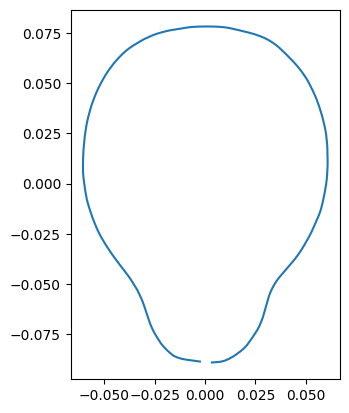

In [32]:
landmark_num = res # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(seed_arr, landmark_num, dim_num)

pca = PCA(n_components=2) # perform PCA to align along longest axis
pca = pca.fit_transform(mean_shape)

rot_x, rot_y = rotate_points(pca[:,0], pca[:,1], 180) # rotate mean leaf upwards
rot_mean = np.column_stack((rot_x, rot_y))

plt.plot(rot_mean[:,0], rot_mean[:,1]) # plot mean leaf
plt.gca().set_aspect("equal")

Text(0.5, 1.0, 'overall mean seed')

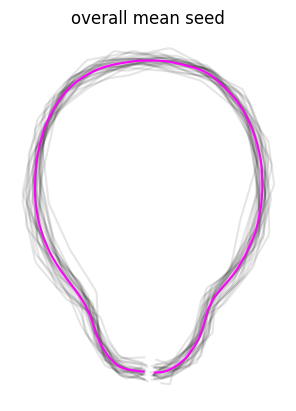

In [40]:
###############################
### ALIGN SEEDS TO GPA MEAN ###
###############################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(seed_arr)) 

for i in range(len(seed_arr)):
    s1, s2, distance = procrustes(rot_mean, seed_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current seed
    proc_arr[i] = s2 # store procrustes adjusted shape to array

for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.1)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean seed")

In [42]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 26 
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )

PC: var, overall 
PC1: 54.7%, 54.7%
PC2: 22.2%, 76.9%
PC3: 7.2%, 84.0%
PC4: 3.7%, 87.7%
PC5: 2.8%, 90.5%
PC6: 2.0%, 92.5%
PC7: 1.5%, 94.0%
PC8: 1.1%, 95.2%
PC9: 0.9%, 96.1%
PC10: 0.6%, 96.7%
PC11: 0.5%, 97.2%
PC12: 0.5%, 97.7%
PC13: 0.4%, 98.1%
PC14: 0.3%, 98.5%
PC15: 0.3%, 98.8%
PC16: 0.2%, 99.0%
PC17: 0.2%, 99.2%
PC18: 0.2%, 99.4%
PC19: 0.2%, 99.5%
PC20: 0.1%, 99.7%
PC21: 0.1%, 99.8%
PC22: 0.1%, 99.8%
PC23: 0.1%, 99.9%
PC24: 0.0%, 100.0%
PC25: 0.0%, 100.0%
PC26: 0.0%, 100.0%


In [44]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # select number for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# create dataframe for plotting
mdata = pd.DataFrame({
    "group":group_list,
})

# add the PCs to the dataframe
for i in range(PC_NUMBER):
    mdata["PC"+str(i+1)] = PCs[:,i]

PC: var, overall 
PC1: 54.7%, 54.7%
PC2: 22.2%, 76.9%


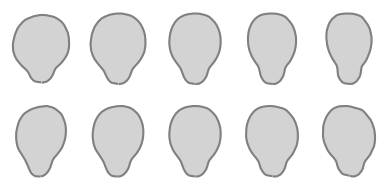

In [47]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
stdev_list = [] # list to store standard deviations for each PC
for i in range(PC_NUMBER):
    stdev_list.append(mdata["PC"+str(i+1)].std())

# create an array of PC values to reconstruct
# for each PC_NUMBER
# calculate PC_NUMBER values
# for each standard deviation value in sdev_vals
sdev_vals = [-2,-1,0,1,2] # standard deviation values to calculate
PC_vals = np.zeros((PC_NUMBER,PC_NUMBER,5)) # an array of PC values to evaluate
for i in range(PC_NUMBER): # for the ith PC
    for j in range(len(sdev_vals)): # for each standard deviation position
        PC_vals[i,i,j] = sdev_vals[j]*stdev_list[i]

# Plot
plt.figure(figsize=(4,2))

counter = 1

for i in range(np.shape(PC_vals)[0]):
    for j in range(len(sdev_vals)):
    
        # create inverse leaf
        inv_leaf = pca.inverse_transform(np.array(PC_vals[i,:,j]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot inverse leaf
        plt.subplot(PC_NUMBER,len(sdev_vals),counter)
        plt.fill(inv_x, inv_y, c="lightgray")
        plt.plot(inv_x, inv_y, c="gray")
        plt.gca().set_aspect("equal")
        plt.axis("off")
        
        counter += 1

plt.tight_layout()

Text(0.5, 1.0, 'Seeds')

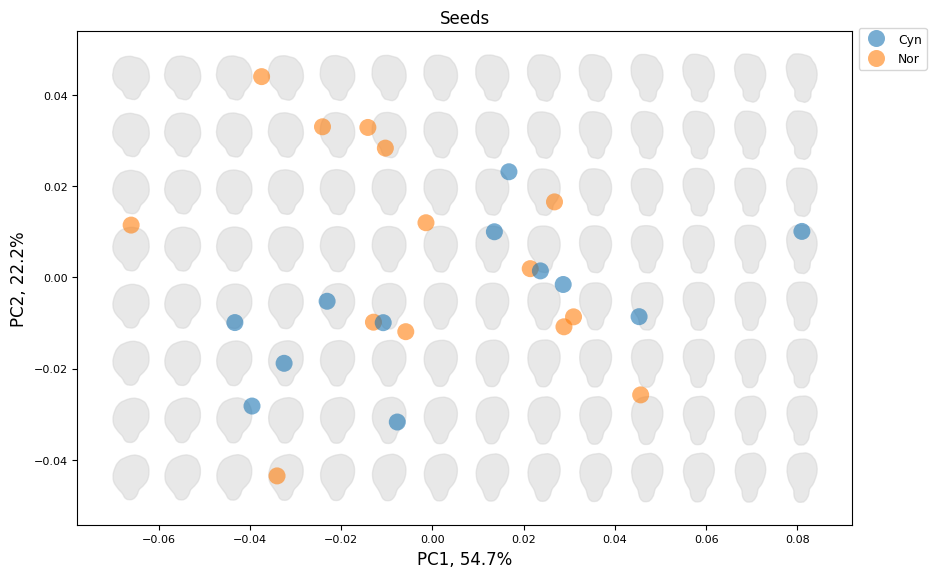

In [61]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPCa = 14 # set number of PCa intervals
numPCb = 8 # set number of PCb intervals
hue = "group" # select the factor to color by
s = 0.06 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 150 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Seeds" # set title

### Set PC index values to plot
##########################
PCa = 0 # index position of first PC
PCb = 1 # index position of second PC
##########################

PCa_vals = np.linspace( np.min(PCs[:,PCa]), np.max(PCs[:,PCa]), numPCa ) # create PC intervals
PCb_vals = np.linspace( np.min(PCs[:,PCb]), np.max(PCs[:,PCb]), numPCb )

plt.figure(figsize=(plot_length, plot_width))

for i in PCa_vals: # for each PCa interval
    for j in PCb_vals: # for each PCb interval
        
        pca_val = i # select the current PCa val
        pcb_val = j # select the current PCb val

        eigen_arr = np.zeros((PC_NUMBER)) # create an array for eigenleaf, length of number of PCs
        eigen_arr[PCa] = pca_val # set the PCa value
        eigen_arr[PCb] = pcb_val # set the PCb value
        
        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(eigen_arr)
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pca_val, inv_y*s+pcb_val, c=lf_col, alpha=lf_alpha)

# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC"+str(PCa+1), y="PC"+str(PCb+1), hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha, legend=True)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC"+str(PCa+1)+", " + str(round(pca.explained_variance_ratio_[PCa]*100,1)) + "%"
ylab = "PC"+str(PCb+1)+", " + str(round(pca.explained_variance_ratio_[PCb]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

# Linear Discriminant Analysis

In [63]:
k=5 # set K-fold sampling value

value_counts = mdata["group"].value_counts() # get value counts for each class
include = value_counts[value_counts > k].index.tolist() # get IDs within K threshold

include_indices = mdata[mdata["group"].isin(include)].index.tolist() # get indices to include

# Create new DataFrame with selected indices
lda_df = mdata.iloc[include_indices].copy()

# Reset the index of the new DataFrame
lda_df = lda_df.reset_index(drop=True)

# create array with only indices
lda_arr = flat_arr[include_indices]

In [64]:
# create a df for LDA by genotype
geno_df = pd.DataFrame(data=lda_arr)

# add the genotype labels
geno_df["geno"] = lda_df["group"]

# create input and output variables
X = geno_df.iloc[:,0:400]
y = geno_df.iloc[:,400]

# initialize the LDA model
geno_model = LinearDiscriminantAnalysis()

# create a StratifiedKFold object with k
skf = StratifiedKFold(n_splits=k)

# initialize an empty confusion matrix
cm = np.zeros((len(y.unique()), len(y.unique())), dtype=int)

# perform stratified k-fold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the LDA model on the training data
    geno_model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = geno_model.predict(X_test)

    # Update the confusion matrix
    cm += confusion_matrix(y_test, y_pred)

# normalize 
norm_cm = np.zeros(np.shape(cm))

for i in range(len(cm)):
    row_sum = np.sum(cm[i,:])
    norm_cm[i,:] = cm[i,:]/row_sum



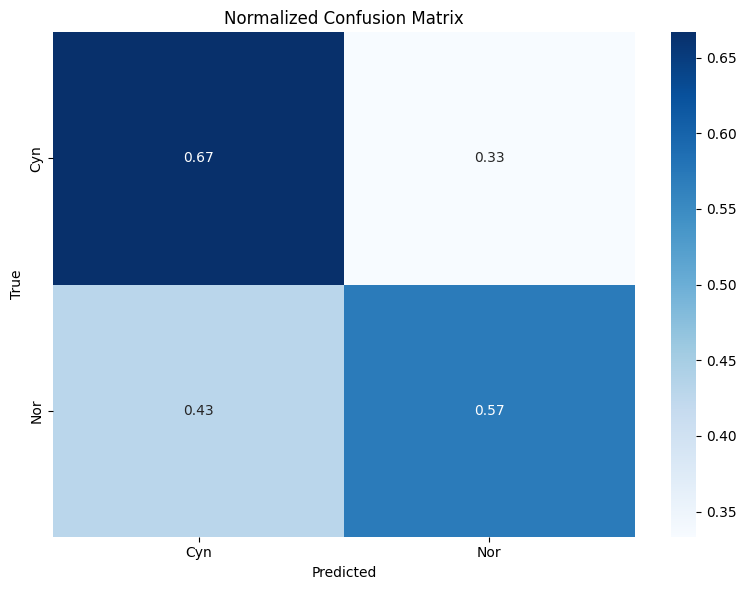

In [65]:
# assuming 'y' contains the class labels
labels = y.unique()

# plot the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(norm_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

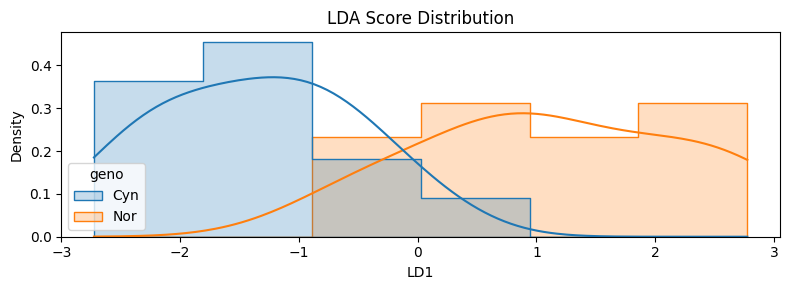

In [69]:
# Fit the model on the entire dataset
geno_model.fit(X, y)

# Transform the data to LDA space
lda_scores = geno_model.transform(X)

# Convert to DataFrame for plotting
lda_df = pd.DataFrame(lda_scores, columns=[f"LD{i+1}" for i in range(lda_scores.shape[1])])
lda_df["geno"] = y.values


# For binary classification, LDA has only one discriminant axis
plt.figure(figsize=(8, 3))
sns.histplot(data=lda_df, x="LD1", hue="geno", element="step", stat="density", common_norm=False, kde=True)
plt.title("LDA Score Distribution")
plt.xlabel("LD1")
plt.tight_layout()
plt.show()
